Soumyadip Roy

---



Making the neural network classifier

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
import time

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import neuralnetworks as nn

# Extend the nn.NeuralNetwork class to reuse much of its implementation
# Only those methods that must be altered to do classification are defined in NeuralNetworkClassifier

class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):

        # Force n_hidens_list to be a list
        
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 
        # Call the constructor for NeuralNetwork, passing in the number of unique class names (ints)
        # as the number of outputs
        
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)

        # Store as member variables other things needed by instances of this class.
        
        self.classes = np.array(classes) # to allow argmax in use()
        
        if use_torch:
            self.log = torch.log
            self.exp = torch.exp
        else:
            self.log = np.log
            self.exp = np.exp
        

# insert the rest of your class methods here.
    def __repr__(self):
        
        return super().__repr__()
    
    
    def _standardizeT(self, T):
        return T

    def _unstandardizeT(self, Ts):
        return Ts
    
    def g12(self, X):
        fs = self.exp(X)
        denom = np.sum(fs, axis=1).reshape((-1,1))
        # pdb.set_trace()
        gs = fs / denom
        # print(gs[:10,:])
        return gs
    
    def _forward_pass(self, X):
        Y,Z=super()._forward_pass(X)
        Y=self.g12(Y)
        return Y,Z
  
   
      
    def makeIndicatorVars(self, T):
        # Make sure T is two-dimensional. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1,1))    
        return (T == np.unique(T)).astype(int)

    def _objectiveF(self, w, X, T):
        super()._unpack(w)
        # Do forward pass through all layers
        Y, Z = self._forward_pass(X)
        Y1 = np.mean(self.log(Y)*T)
        return Y1 * (-1)
      
    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)

      
   
      
      
    def train(self, X, T, n_epochs, method='scg',   verbose=False, save_weights_history=False,         learning_rate=0.001, momentum_rate=0.0): # only for sgd and adam

        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]}) not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float)  # 32 bit
            T = torch.tensor(T, dtype=torch.float)

        T = self.makeIndicatorVars(T)
        super()._setup_standardize(X, T)
        X = super()._standardizeX(X)
        T = self._standardizeT(T)
        
        try:
            algo = [opt.sgd, opt.adam, opt.scg][['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            

        result = algo(super()._pack(self.Vs, self.W),
                      self._objectiveF, [X, T], n_epochs,
                      super()._gradientF,  # not used if scg
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch,
                      save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] # * self.Tstds # to _unstandardize the MSEs
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self

    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
        X = super()._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        gs = self.g12(Y)
        op1=[0]*len(X)
        for i in range(len(X)):
            #print(np.where(gs[i]==(max(gs[i]))),max(gs[i]))
            op1[i]=self.classes[gs[i].tolist().index(max(gs[i]))]
            #op[i]=(np.where(gs[i]==(max(gs[i]))))
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        op1=list(op1)  
        op1=np.array(op1).reshape(-1,1)
        return (op1,gs, Z[1:]) if all_outputs else  (op1,gs) 


Making X and Y to test the Neuralnetworks.py file uploaded

In [0]:
X = np.arange(20).reshape((10, 2)) * 0.1
T = np.hstack((X[:, 0:1]**2, np.sin(X[:, 1:2])))
X.shape, T.shape

((10, 2), (10, 2))

In [0]:
X


array([[0. , 0.1],
       [0.2, 0.3],
       [0.4, 0.5],
       [0.6, 0.7],
       [0.8, 0.9],
       [1. , 1.1],
       [1.2, 1.3],
       [1.4, 1.5],
       [1.6, 1.7],
       [1.8, 1.9]])

In [0]:
T

array([[0.        , 0.09983342],
       [0.04      , 0.29552021],
       [0.16      , 0.47942554],
       [0.36      , 0.64421769],
       [0.64      , 0.78332691],
       [1.        , 0.89120736],
       [1.44      , 0.96355819],
       [1.96      , 0.99749499],
       [2.56      , 0.99166481],
       [3.24      , 0.94630009]])

Plotting T

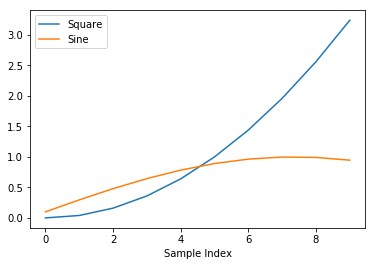

In [0]:
plt.plot(T)
plt.xlabel('Sample Index')
plt.legend(['Square', 'Sine']);

Initializing Neural Network of neuralnetwork.py

In [0]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)  Network is not trained.

Training it

In [0]:
nnet.train(X, T, 50, method='scg')
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0393 seconds. Final objective value is 0.074

Plotting Error trace

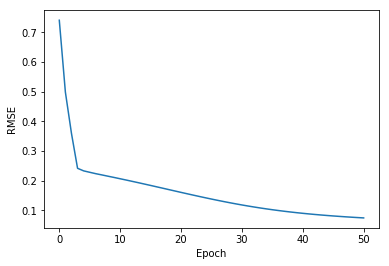

In [0]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

In [0]:
nnet


NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0393 seconds. Final objective value is 0.074

Testing the Function with the same values that has been used for training

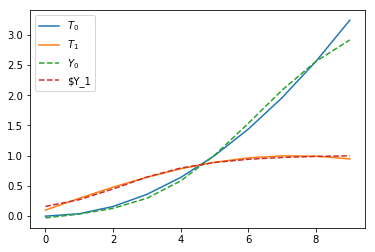

In [0]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

Doing the same thing with SGD

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0255 seconds. Final objective value is 0.212


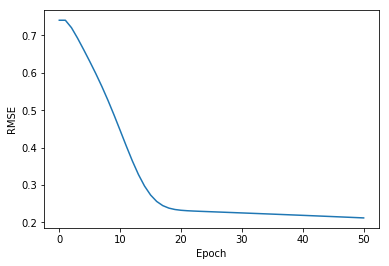

In [0]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet.train(X, T, 50, method='sgd', learning_rate=0.1, momentum_rate=0.5)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

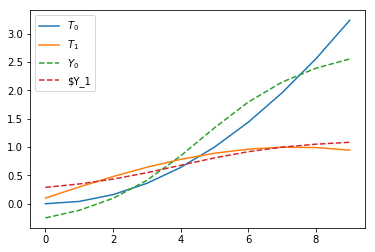

In [0]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

Now with Adam

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0282 seconds. Final objective value is 0.037


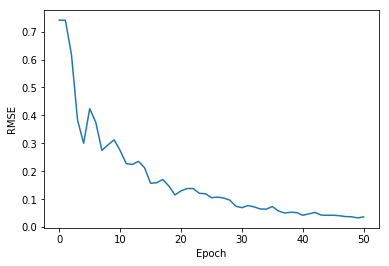

In [0]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet.train(X, T, 50, method='adam', learning_rate=0.1)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

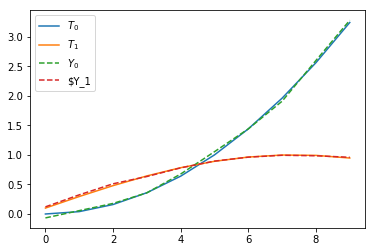

In [0]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

NeuralNetwork(2, [10, 10], 2, use_torch=True)
   Network was trained for 50 epochs that took 0.2560 seconds. Final objective value is 0.036


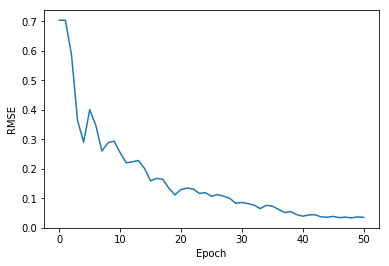

In [0]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2, use_torch=True)
nnet.train(X, T, 50, method='adam', learning_rate=0.1)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');


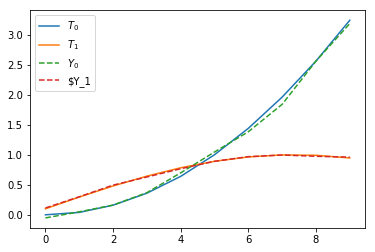

In [0]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

Initializing new values of X and T

In [0]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

n_samples = 20
X = np.random.choice(3, (n_samples, 2))
T = (X[:, 0:1] == X[:, 1:2]).astype(int)  # where the two inputs are equal
classes = [0, 1]

for x, t in zip(X, T):
    print(f'x = {x}, t = {t}')

x = [2 0], t = [0]
x = [2 2], t = [1]
x = [0 0], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [2 2], t = [1]
x = [0 2], t = [0]
x = [1 0], t = [0]
x = [1 1], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [0 2], t = [0]
x = [2 2], t = [1]
x = [1 2], t = [0]
x = [1 1], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [0 2], t = [0]


In [0]:
print(f'{np.sum(T==0)} not equal, {np.sum(T==1)} equal')


8 not equal, 12 equal


Initializing our Neural Network Class

In [0]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1])
nnet_new

NeuralNetworkClassifier(2, [10, 10], 2, use_torch=False)  Network is not trained.

In [0]:
nnet_new._standardizeT(T)


array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [0]:
nnet_new._unstandardizeT(T)


array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [0]:
nnet_new._setup_standardize(X, T)
Xst = nnet_new._standardizeX(X)
Xst

array([[ 1.08347268, -1.47709789],
       [ 1.08347268,  0.98473193],
       [-1.32424438, -1.47709789],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193],
       [-0.12038585, -1.47709789],
       [-0.12038585, -0.24618298],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-1.32424438,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-0.12038585,  0.98473193],
       [-0.12038585, -0.24618298],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193]])

Testing the forward pass of the network

In [0]:
Y, Z = nnet_new._forward_pass(Xst)
Y

array([[0.55163905, 0.44836095],
       [0.52855705, 0.47144295],
       [0.59590952, 0.40409048],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539],
       [0.57163885, 0.42836115],
       [0.56395347, 0.43604653],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.59746461, 0.40253539],
       [0.52855705, 0.47144295],
       [0.56007003, 0.43992997],
       [0.56395347, 0.43604653],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539]])

Testing the objective functon

In [0]:
w = nnet_new._pack(nnet_new.Vs, nnet_new.W)

T_indicator_vars = np.hstack((1 - T, T))  # this only works for this particular two-class toy data

nnet_new._objectiveF(w, X, T_indicator_vars)

0.35253287777714165

Training the network

In [0]:
nnet_new.train(X, T, 100)

NeuralNetworkClassifier(2, [10, 10], 2, use_torch=False)
   Network was trained for 66 epochs that took 0.0631 seconds. Final objective value is 1.000

Testing the network with the same values used for training 

In [0]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

((20, 1), (20, 2))

Plotting graph to see error and difference between actual and predicted classes

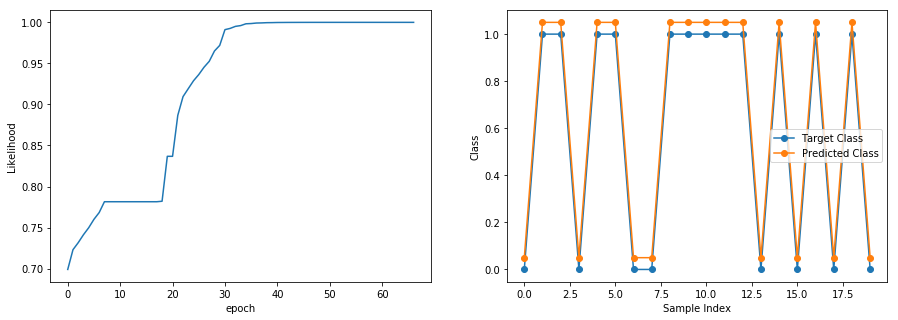

In [0]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

In [0]:
#%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Roy-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetworkClassifier can learn to detect vowels when given
their ascii codes.

import numpy as np
ascii_code = list(range(65, 91)) + list(range(97, 123))
chars = [chr(n).lower() for n in ascii_code]
vowel = [c in ['a', 'e', 'i', 'o', 'u'] for c in chars]
X = np.array(ascii_code).reshape((-1, 1))
T = np.array(vowel).reshape((-1, 1))
classes = np.unique(T)

np.random.seed(120)
nnet = NeuralNetworkClassifier(X.shape[1], [50, 20, 20], classes)
nnet.train(X, T, 10000, verbose=True)
Yc, Y = nnet.use(X)
n_correct = (Yc == T).sum()
print(f'{n_correct} out of {T.shape[0]} samples, or {n_correct/T.shape[0]*100:.2f} percent.')
SCG: Iteration 1000 ObjectiveF=0.79863 Scale=1.000e-15 Seconds=1.431
SCG: Iteration 2000 ObjectiveF=0.80751 Scale=1.000e

notebookcodeStripped:57: RuntimeWarning: overflow encountered in exp
notebookcodeStripped:60: RuntimeWarning: invalid value encountered in true_divide
notebookcodeStripped:81: RuntimeWarning: divide by zero encountered in log
notebookcodeStripped:81: RuntimeWarning: invalid value encountered in multiply


SCG: Iteration 4000 ObjectiveF=0.82552 Scale=1.000e-15 Seconds=1.547
SCG: Iteration 5000 ObjectiveF=0.84690 Scale=1.000e-15 Seconds=1.501
SCG: Iteration 6000 ObjectiveF=0.85865 Scale=1.000e-15 Seconds=1.536
SCG: Iteration 7000 ObjectiveF=0.86317 Scale=1.000e-15 Seconds=1.531
SCG: Iteration 8000 ObjectiveF=0.88484 Scale=1.000e-15 Seconds=1.550
SCG: Iteration 9000 ObjectiveF=0.94793 Scale=1.000e-15 Seconds=1.490
SCG: Iteration 10000 ObjectiveF=0.96082 Scale=1.000e-15 Seconds=1.520
51 out of 52 samples, or 98.08 percent.

--- 80/80 points. Returned correct value of 51.

content Execution Grade is 80 / 80

 __ / 10 You obtained data for a classification problem and set up
         X and T matrices correctly.

 __ / 10 You compared several different network sizes, numbers of
         epochs, and optimization algoritms and described the results.

content FINAL GRADE is  _  / 100

Extra Credit:
1. For the data set you have downloaded, randomly partition the data into about
   80% for training

I have used the Iris Dataset for testing. It consists of 4 features and 4 classes. **This is also same as the first part of Extra Credit since I have partitioned the Iris Dataset into 80% for training and 20% for testing and I have also discussed the results.** 

In [0]:
from sklearn import datasets
iris = datasets.load_iris()

I have separated the features in X and the class labels in Y

In [0]:
X = iris.data[:, :] 
T = iris['target']


I have separated randomly the dataset into training and testing dataset. 80% is used for training dataset and 20% is used for testng purposes.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)

Below I have printed the training and testing classes of both input and labels

In [0]:
print(X_train,T_train)

[[6.3 2.8 5.1 1.5]
 [4.9 3.1 1.5 0.1]
 [5.7 2.8 4.1 1.3]
 [6.5 3.  5.2 2. ]
 [6.9 3.1 5.4 2.1]
 [5.1 3.4 1.5 0.2]
 [4.6 3.6 1.  0.2]
 [6.9 3.2 5.7 2.3]
 [5.6 2.7 4.2 1.3]
 [5.5 2.6 4.4 1.2]
 [5.9 3.  4.2 1.5]
 [4.8 3.1 1.6 0.2]
 [5.  3.3 1.4 0.2]
 [7.3 2.9 6.3 1.8]
 [5.6 2.8 4.9 2. ]
 [7.4 2.8 6.1 1.9]
 [5.7 2.8 4.5 1.3]
 [5.4 3.9 1.7 0.4]
 [4.8 3.  1.4 0.3]
 [5.2 3.4 1.4 0.2]
 [5.6 2.9 3.6 1.3]
 [6.  2.2 4.  1. ]
 [5.  3.5 1.6 0.6]
 [6.  2.9 4.5 1.5]
 [5.3 3.7 1.5 0.2]
 [6.2 2.9 4.3 1.3]
 [4.6 3.1 1.5 0.2]
 [6.4 3.2 5.3 2.3]
 [6.8 2.8 4.8 1.4]
 [5.  3.6 1.4 0.2]
 [6.1 2.9 4.7 1.4]
 [5.1 3.8 1.6 0.2]
 [5.2 3.5 1.5 0.2]
 [6.7 3.  5.  1.7]
 [6.3 2.5 4.9 1.5]
 [5.4 3.  4.5 1.5]
 [6.3 2.3 4.4 1.3]
 [5.  3.4 1.6 0.4]
 [6.9 3.1 5.1 2.3]
 [5.  2.3 3.3 1. ]
 [7.  3.2 4.7 1.4]
 [6.3 3.4 5.6 2.4]
 [4.7 3.2 1.6 0.2]
 [5.1 3.7 1.5 0.4]
 [6.6 2.9 4.6 1.3]
 [6.6 3.  4.4 1.4]
 [7.1 3.  5.9 2.1]
 [6.7 3.1 4.7 1.5]
 [5.4 3.9 1.3 0.4]
 [5.6 3.  4.5 1.5]
 [7.9 3.8 6.4 2. ]
 [5.  3.4 1.5 0.2]
 [7.2 3.  5.

In [0]:
print(X_test,T_test)

[[4.8 3.  1.4 0.1]
 [4.4 3.2 1.3 0.2]
 [5.1 3.8 1.9 0.4]
 [7.7 3.8 6.7 2.2]
 [6.3 3.3 4.7 1.6]
 [7.7 3.  6.1 2.3]
 [5.7 4.4 1.5 0.4]
 [4.9 2.4 3.3 1. ]
 [6.7 3.1 5.6 2.4]
 [6.3 2.5 5.  1.9]
 [5.8 2.7 3.9 1.2]
 [5.5 2.4 3.8 1.1]
 [4.9 2.5 4.5 1.7]
 [6.1 2.6 5.6 1.4]
 [6.  2.2 5.  1.5]
 [7.2 3.2 6.  1.8]
 [6.1 3.  4.6 1.4]
 [6.7 3.  5.2 2.3]
 [5.9 3.  5.1 1.8]
 [7.6 3.  6.6 2.1]
 [6.2 2.8 4.8 1.8]
 [5.9 3.2 4.8 1.8]
 [5.8 4.  1.2 0.2]
 [5.5 4.2 1.4 0.2]
 [6.9 3.1 4.9 1.5]
 [6.  3.4 4.5 1.6]
 [7.7 2.8 6.7 2. ]
 [6.5 2.8 4.6 1.5]
 [5.  3.  1.6 0.2]
 [6.1 2.8 4.7 1.2]] [0 0 0 2 1 2 0 1 2 2 1 1 2 2 2 2 1 2 2 2 2 1 0 0 1 1 2 1 0 1]


Taking out all the unque classes

In [0]:
class23=np.unique(T_train)
class23

array([0, 1, 2])

Intialising Network

In [0]:
nnet_new1 = NeuralNetworkClassifier(4, [10, 10], class23)
nnet_new1

NeuralNetworkClassifier(4, [10, 10], 3, use_torch=False)  Network is not trained.

Training the network

In [0]:
nnet_new1.train(X_train, T_train, 100)

NeuralNetworkClassifier(4, [10, 10], 3, use_torch=False)
   Network was trained for 100 epochs that took 0.1305 seconds. Final objective value is 0.987

Testing  the network with the test separated values 

In [0]:
Yc,Y=nnet_new1.use(X_test)

Finding number of correct samples

In [0]:
n_correct=0
T_test=np.array(T_test).reshape(-1,1)
n_correct = (T_test == Yc).sum()
per=n_correct/len(T_test)*100
print('accuracy is {}'.format(per))

accuracy is 96.66666666666667


Showing the confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Yc, T_test)
print(cm)

[[ 8  0  0]
 [ 0 10  0]
 [ 0  1 11]]


So we can see there are 8 samples of Class0 , 10 samples of Class 1 and 11 samples of Class 2 which are correctly classified and 1 sample of Class 2 is misclassfied as Class 1. So our accuracy is 96.667%

Now plotting the predicted class and the Target Test Dataset

Text(0.5, 1.0, 'Predicted vs Target Class of Test Dataset')

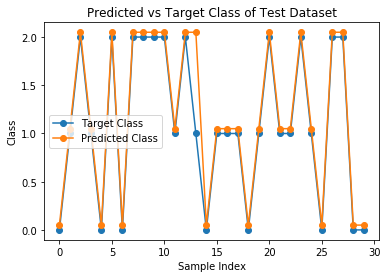

In [0]:


plt.plot(T_test, 'o-')
plt.plot(Yc + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);
plt.title('Predicted vs Target Class of Test Dataset')

Now we will create a function that wil call the methods of Adam and SGD for a number of epochs, learning rates, momemtum rates  and different hiddent hidden layers.

In [0]:
from sklearn.metrics import confusion_matrix
def classifymodel(X_train,X_test,Y_train,Y_test,N,hidden_layers,method1,lr,mr,epoch):
  class1=np.unique(Y_train)

  nnet_new1 = NeuralNetworkClassifier(N, hidden_layers, class1)
  nnet_new1.train( X_train, Y_train, n_epochs=epoch, method=method1,           learning_rate=lr, momentum_rate=mr)
  Yc,Y=nnet_new1.use(X_test)
  n_correct=0
  Y_test=np.array(Y_test).reshape(-1,1)
  n_correct = (Y_test == Yc).sum()
  per=n_correct/len(Y_test)*100
  #print('accuracy is {}'.format(per))
  cm=confusion_matrix(Yc, Y_test)
  return per , cm

In [0]:
N=X_train.shape[1]
lr1=[0.001, 0.01,0.1]
mr1=[0.001,0.01,0.1]
methods=['sgd','adam']
h1=[[5,5],[10,10],[5,5,5],[10,10,10]]
accg=[]
epoch=[70,100,200]
for method1 in methods:
  for hidden_layers in h1:
    for mr in mr1:
      accg=[]
      
      for lr in lr1:
        for e1 in epoch:
          acc,cm=classifymodel(X_train,X_test,T_train,T_test,N,hidden_layers,method1,lr,mr,e1)
          #accg.append(acc)
          print('For model={} with number of Hidden layers  ={} with  units in each layer={} with learning rate ={} with epoch={} and momemtum rate ={} the accuracy is {}  '.format(method1,len(hidden_layers),hidden_layers[0],lr,e1,mr,acc))
      

For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.001 with epoch=70 and momemtum rate =0.001 the accuracy is 26.666666666666668  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.001 with epoch=100 and momemtum rate =0.001 the accuracy is 20.0  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.001 with epoch=200 and momemtum rate =0.001 the accuracy is 16.666666666666664  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.01 with epoch=70 and momemtum rate =0.001 the accuracy is 16.666666666666664  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.01 with epoch=100 and momemtum rate =0.001 the accuracy is 36.666666666666664  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.01 with epoch=200 and momemtum 

Below are the graphs for accuracy vs learning Rate and Accuracy vs Momemtum for the testing values used in use function

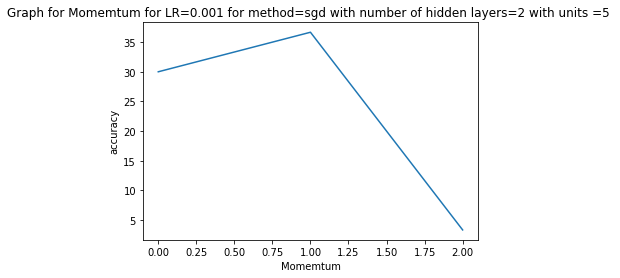

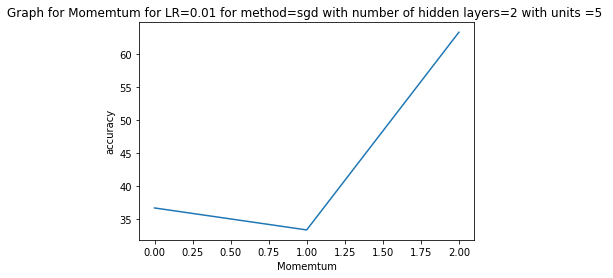

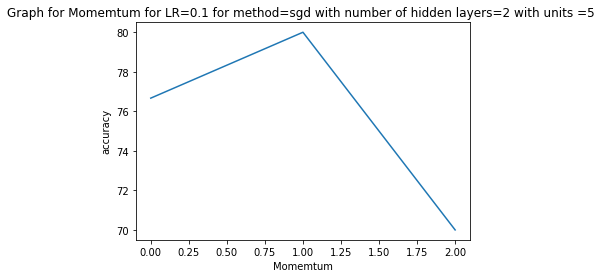

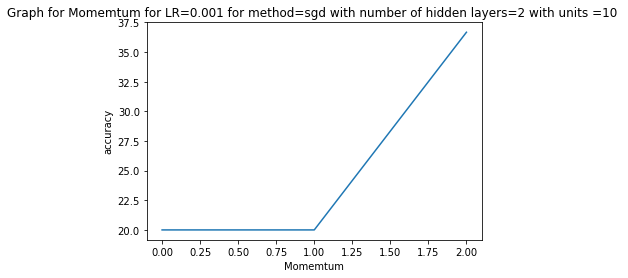

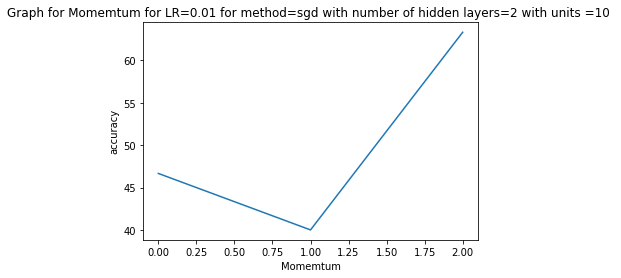

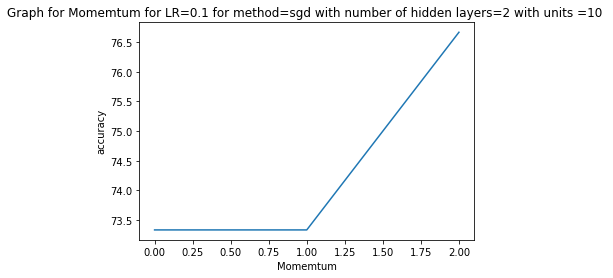

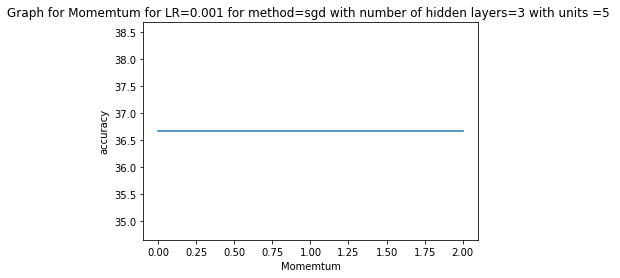

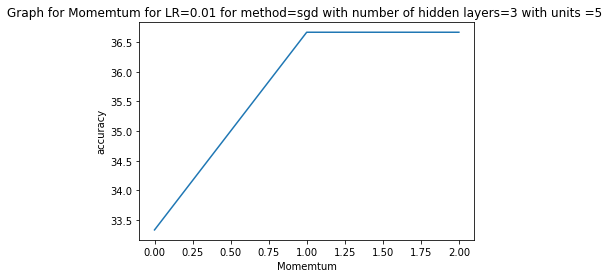

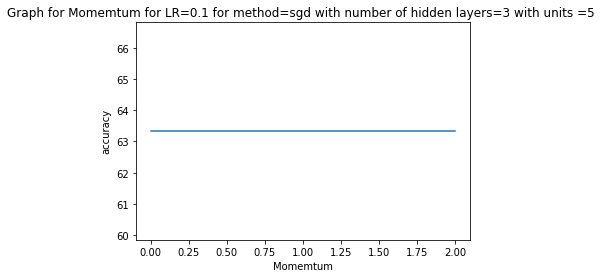

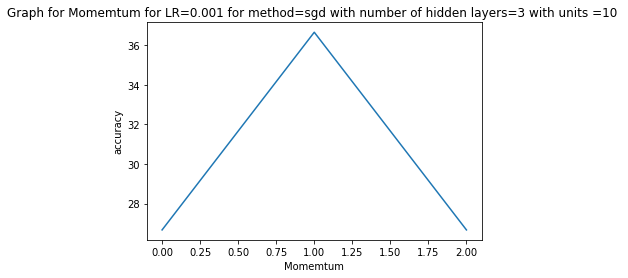

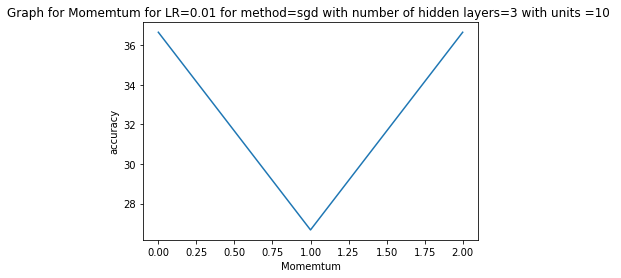

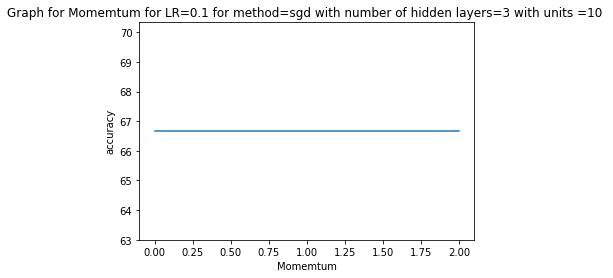

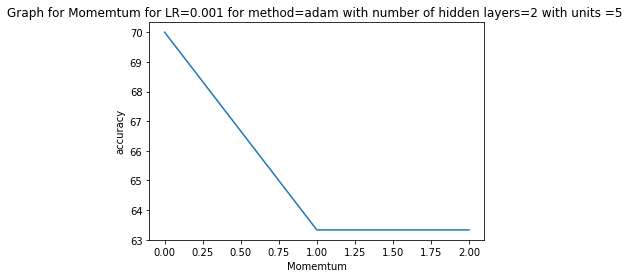

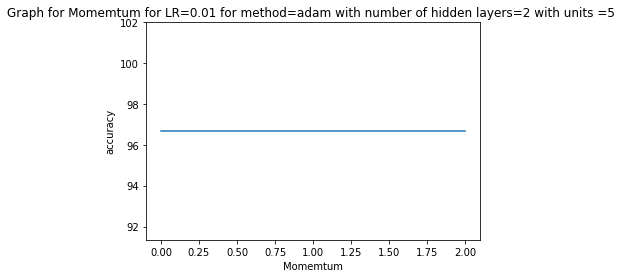

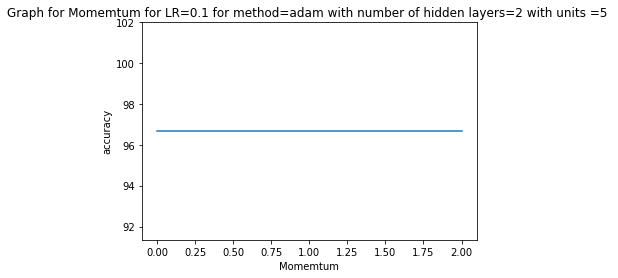

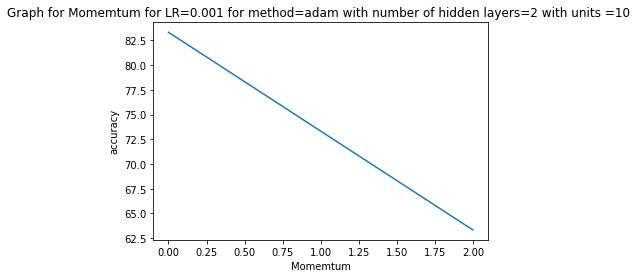

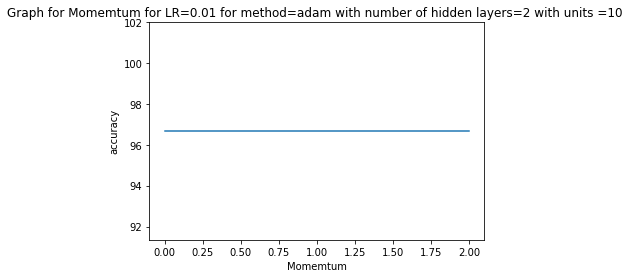

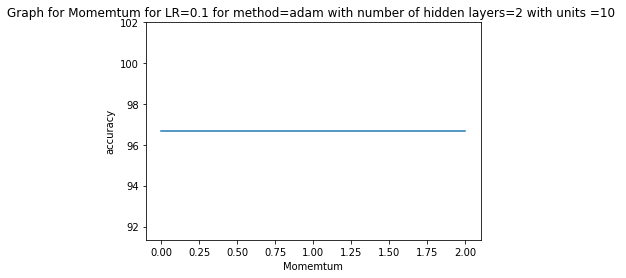

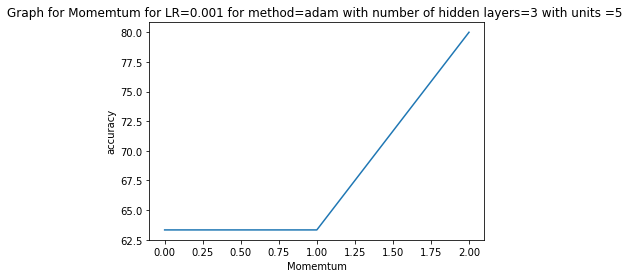

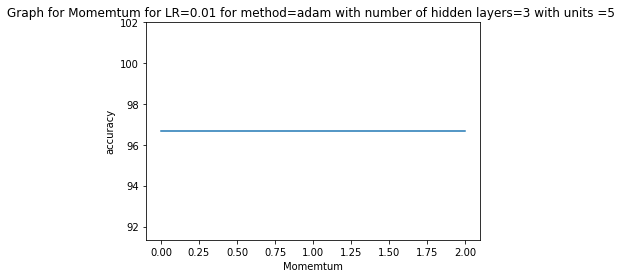

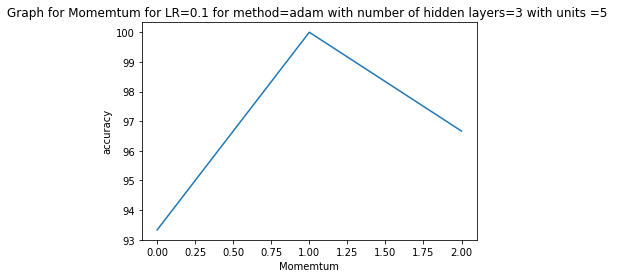

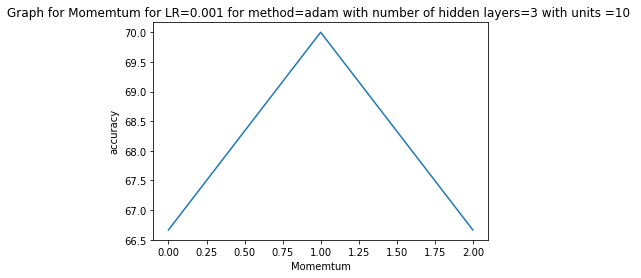

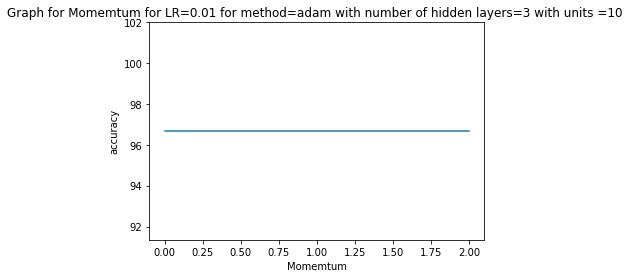

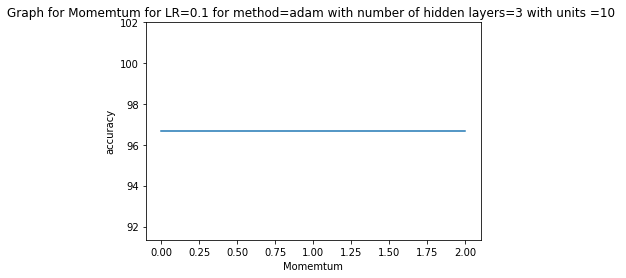

"for method1 in methods:\n  for hidden_layers in h1:\n    for mr in mr1:\n      accg=[]\n      for lr in lr1:\n        \n        acc,cm=classifymodel(X_train,X_test,Y_train,Y_test,N,hidden_layers,method1,lr,mr,epoch)\n        accg.append(acc)\n        #print('For model={} with number of Hidden layers  ={} with  units in each layer={} with learning rate ={} and momemtum rate ={} the accuracy is {}  '.format(method1,len(hidden_layers),hidden_layers[0],lr,mr,acc))\n      plt.plot(accg,lr)\n      plt.title('Graph for Learning Rate for LR={} for method={}  with number of hidden layers={} with units ={} '.format(lr,method1,len(hidden_layers),hidden_layers[0]))\n      plt.xlabel('Learning Rate')\n      plt.ylabel('accuracy')\n      plt.show()"

In [0]:
N=X_train.shape[1]
lr1=[0.001, 0.01,0.1]
mr1=[0.001,0.01,0.1]
methods=['sgd','adam']
h1=[[5,5],[10,10],[5,5,5],[10,10,10]]
accg=[]
epoch=100
for method1 in methods:
  for hidden_layers in h1:
    for lr in lr1:
      accg=[]
      for mr in mr1:
        
        acc,cm=classifymodel(X_train,X_test,T_train,T_test,N,hidden_layers,method1,lr,mr,epoch)
        accg.append(acc)
        #print('For model={} with number of Hidden layers  ={} with  units in each layer={} with learning rate ={} and momemtum rate ={} the accuracy is {}  '.format(method1,len(hidden_layers),hidden_layers[0],lr,mr,acc))
      #print(len(mr1),len(accg))
      plt.plot(accg)
      plt.title('Graph for Momemtum for LR={} for method={} with number of hidden layers={} with units ={} '.format(lr,method1,len(hidden_layers),hidden_layers[0]))
      plt.xlabel('Momemtum')
      plt.ylabel('accuracy')
      plt.show()
      
"""for method1 in methods:
  for hidden_layers in h1:
    for mr in mr1:
      accg=[]
      for lr in lr1:
        
        acc,cm=classifymodel(X_train,X_test,Y_train,Y_test,N,hidden_layers,method1,lr,mr,epoch)
        accg.append(acc)
        #print('For model={} with number of Hidden layers  ={} with  units in each layer={} with learning rate ={} and momemtum rate ={} the accuracy is {}  '.format(method1,len(hidden_layers),hidden_layers[0],lr,mr,acc))
      plt.plot(accg,lr)
      plt.title('Graph for Learning Rate for LR={} for method={}  with number of hidden layers={} with units ={} '.format(lr,method1,len(hidden_layers),hidden_layers[0]))
      plt.xlabel('Learning Rate')
      plt.ylabel('accuracy')
      plt.show()"""
      


So we find that on increasing the Momemtum Rate for a particular Learnng Rate , the accuracy decrease and then increases or first increases and then decreases. So it gives rise to a triangular like shape keeping the number of hidden layers and units in the hidden layers constant. Again if the number of units in each layer is increased and number of hidden layers is also increased we can see that a higher value of accuracy s observed for a lower momemtum again for a higher momemtum that value decreases.

Here Adam Method shows the most good result 

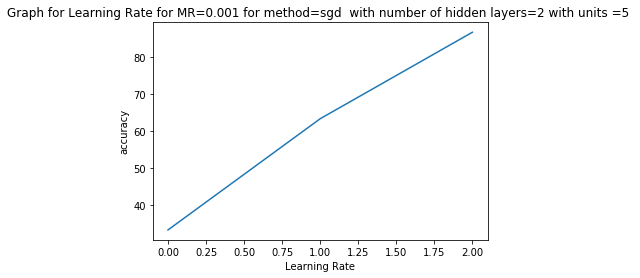

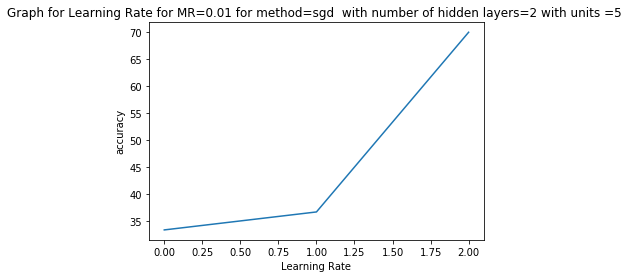

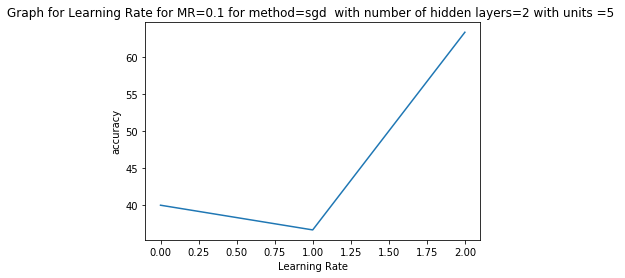

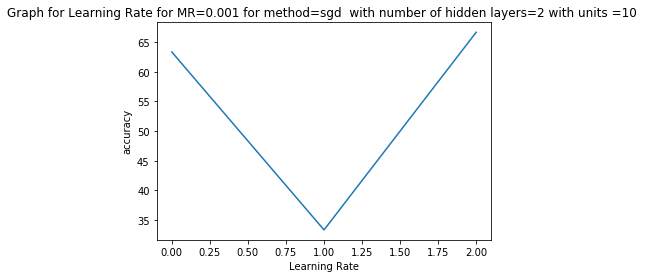

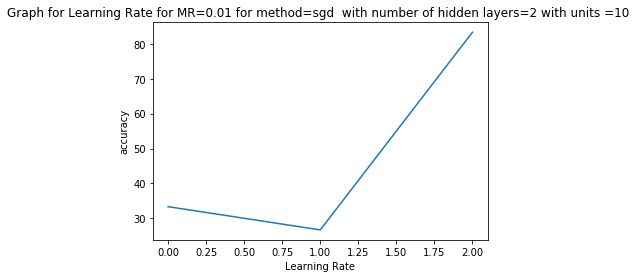

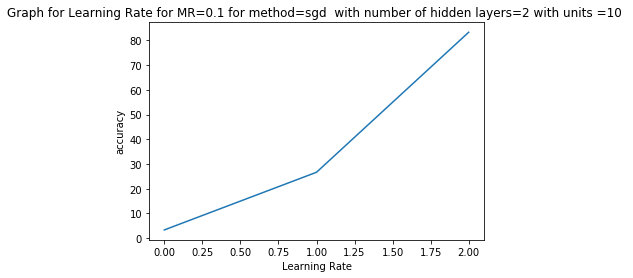

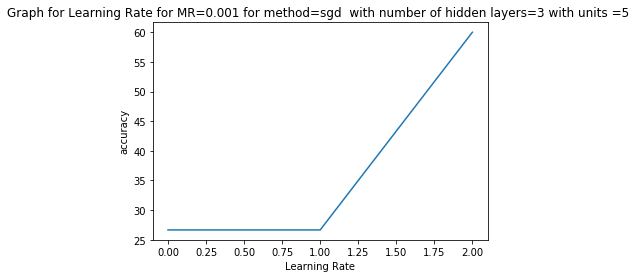

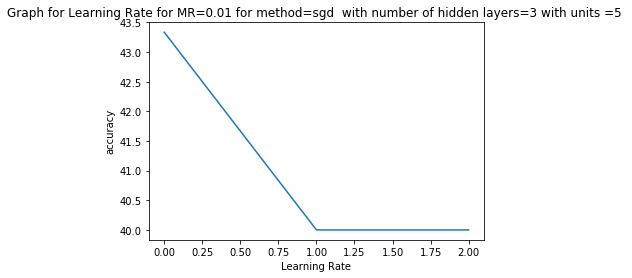

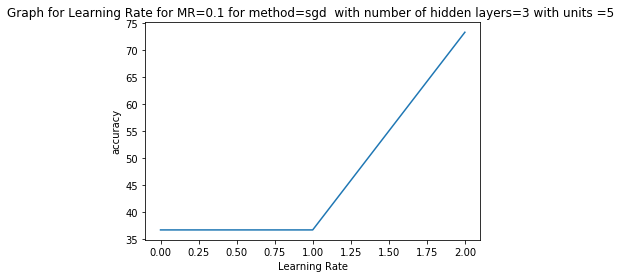

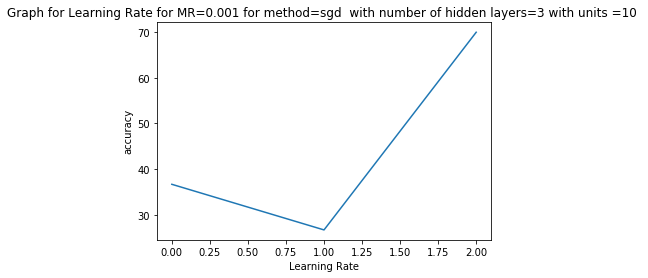

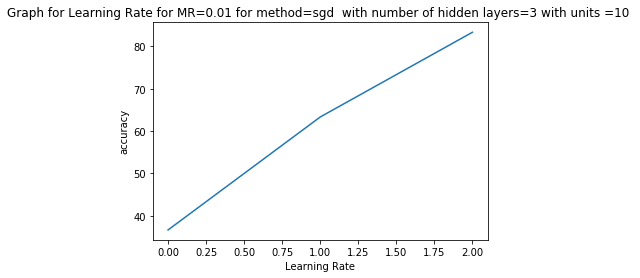

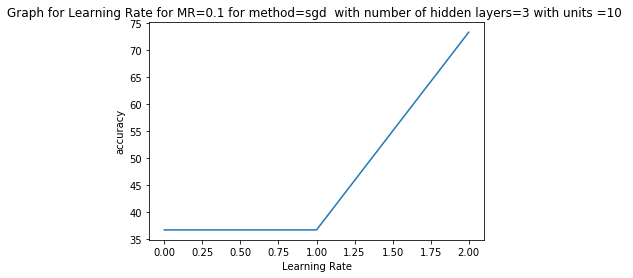

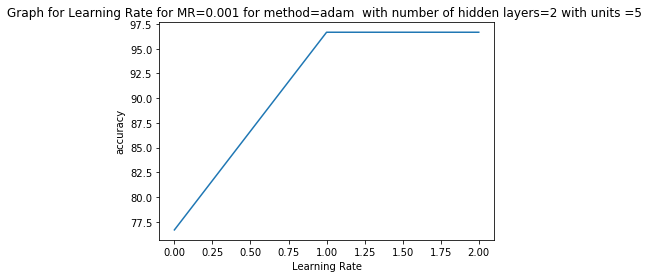

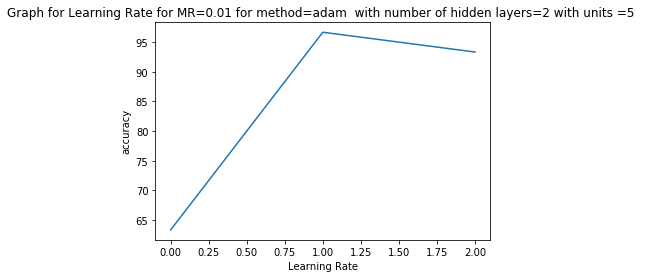

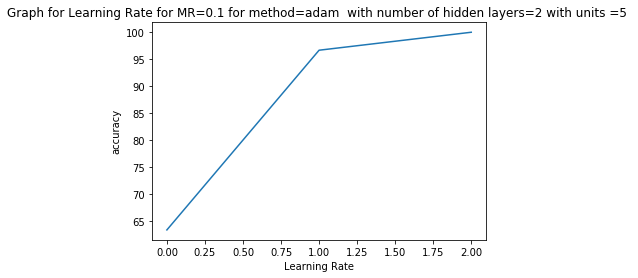

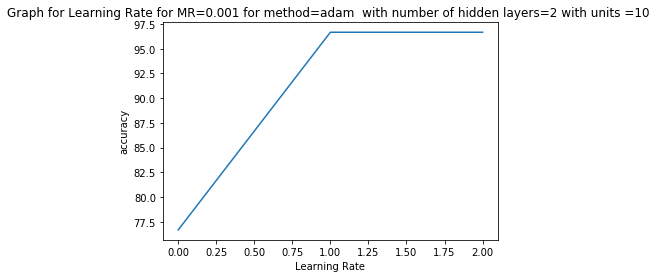

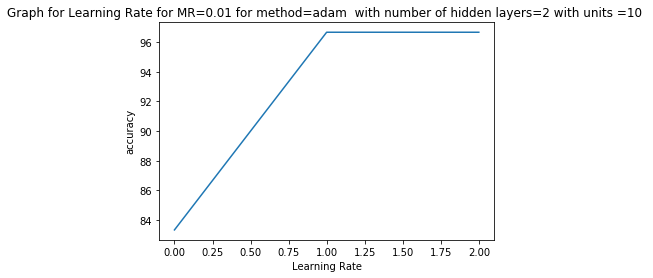

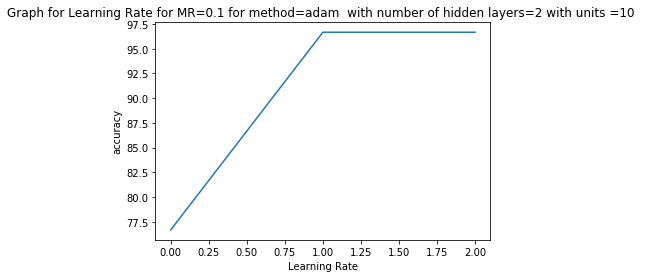

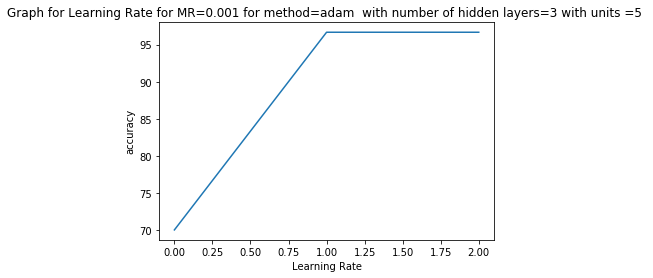

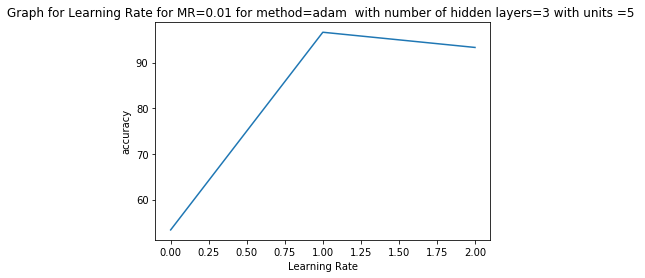

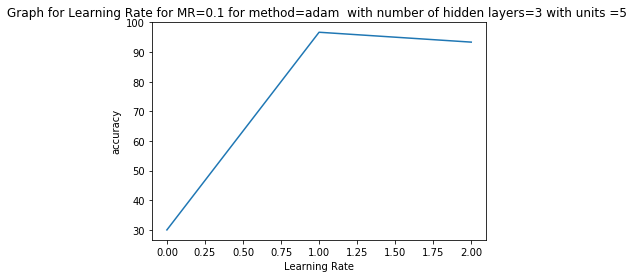

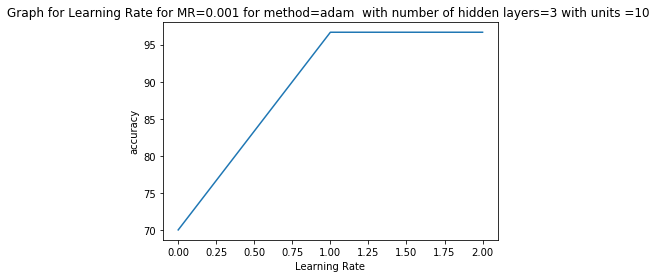

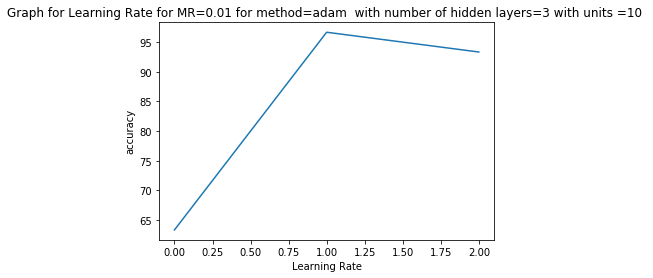

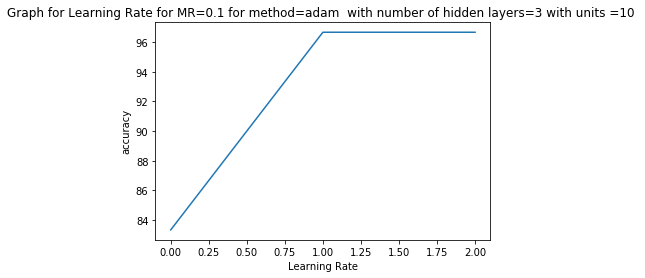

In [0]:
for method1 in methods:
  for hidden_layers in h1:
    for mr in mr1:
      accg=[]
      for lr in lr1:
        
        acc,cm=classifymodel(X_train,X_test,T_train,T_test,N,hidden_layers,method1,lr,mr,epoch)
        accg.append(acc)
        #print('For model={} with number of Hidden layers  ={} with  units in each layer={} with learning rate ={} and momemtum rate ={} the accuracy is {}  '.format(method1,len(hidden_layers),hidden_layers[0],lr,mr,acc))
      
      plt.plot(accg)
      plt.title('Graph for Learning Rate for MR={} for method={}  with number of hidden layers={} with units ={} '.format(mr,method1,len(hidden_layers),hidden_layers[0]))
      plt.xlabel('Learning Rate')
      plt.ylabel('accuracy')
      plt.show()

So we see that if we increase the Learning  rate keeping all the other things constant the accuracy decreases and then it increases in some cases where number of hidden layers is less and number of units s also less. Then as we increase the number of hidden layers we can seee a steady increase in the accuracy keeping all the other things constant. Again as we increase number of units in each layer we can see that accuracy slightly decreases.

Below is the same thing as above but now testing with Training Values 

In [0]:
Yc1,Y1=nnet_new1.use(X_train)

In [0]:
n_correct=0
T_train=np.array(T_train).reshape(-1,1)
n_correct = (T_train == Yc1).sum()
per1=n_correct/len(T_train)*100
print('accuracy is {}'.format(per1))

accuracy is 98.33333333333333


In [0]:
cm=confusion_matrix(Yc1, T_train)
print(cm)

[[42  0  0]
 [ 0 38  1]
 [ 0  1 38]]


So we see that in the training class only one Class 1 is misclassified as Class 2 and  on the other hand 1 Class 2 is misclassified as Class 1. Beow is the graph showing the predicted and actual classes

Text(0.5, 1.0, 'Predicted vs ACtual Class of Training Dataset')

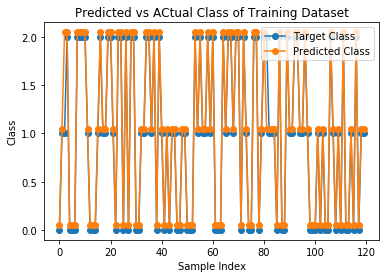

In [0]:


plt.plot(T_train, 'o-')
plt.plot(Yc1 + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);
plt.title('Predicted vs ACtual Class of Training Dataset')

Below the the training values are tested in different optimization functions like adam and sgd with differnt hidden layers, epochs, units in each hidden layer and learning and momemtum rates.

In [0]:
from sklearn.metrics import confusion_matrix
def classifymodel1(X_train,X_test,Y_train,Y_test,N,hidden_layers,method1,lr,mr,epoch):
  class1=np.unique(Y_train)

  nnet_new1 = NeuralNetworkClassifier(N, hidden_layers, class1)
  nnet_new1.train( X_train, Y_train, n_epochs=epoch, method=method1,           learning_rate=lr, momentum_rate=mr)
  Yc,Y=nnet_new1.use(X_train)
  n_correct=0
  Y_train=np.array(Y_train).reshape(-1,1)
  n_correct = (Y_train == Yc).sum()
  per=n_correct/len(Y_train)*100
  #print('accuracy is {}'.format(per))
  cm=confusion_matrix(Yc, Y_train)
  return per , cm

In [0]:
N=X_train.shape[1]
lr1=[0.001, 0.01,0.1]
mr1=[0.001,0.01,0.1]
methods=['sgd','adam']
h1=[[5,5],[10,10],[5,5,5],[10,10,10]]
accg=[]
epoch=[70,100,200]
for method1 in methods:
  for hidden_layers in h1:
    for mr in mr1:
      accg=[]
      
      for lr in lr1:
        for e1 in epoch:
          acc,cm=classifymodel1(X_train,X_test,T_train,T_test,N,hidden_layers,method1,lr,mr,e1)
          #accg.append(acc)
          print('For model={} with number of Hidden layers  ={} with  units in each layer={} with learning rate ={} with epoch={} and momemtum rate ={} the accuracy is {}  '.format(method1,len(hidden_layers),hidden_layers[0],lr,e1,mr,acc))
      

For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.001 with epoch=70 and momemtum rate =0.001 the accuracy is 32.5  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.001 with epoch=100 and momemtum rate =0.001 the accuracy is 49.166666666666664  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.001 with epoch=200 and momemtum rate =0.001 the accuracy is 34.166666666666664  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.01 with epoch=70 and momemtum rate =0.001 the accuracy is 35.0  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.01 with epoch=100 and momemtum rate =0.001 the accuracy is 32.5  
For model=sgd with number of Hidden layers  =2 with  units in each layer=5 with learning rate =0.01 with epoch=200 and momemtum rate =0.001 the accuracy is 

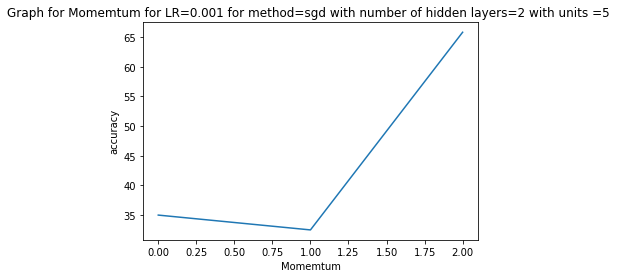

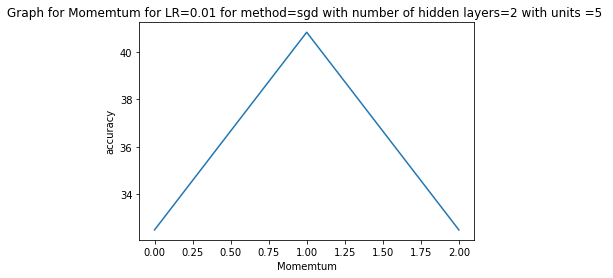

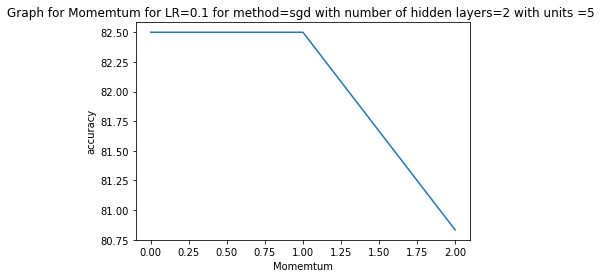

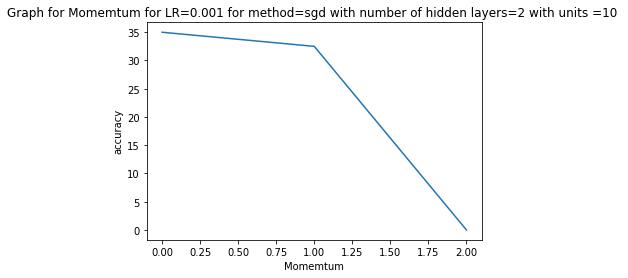

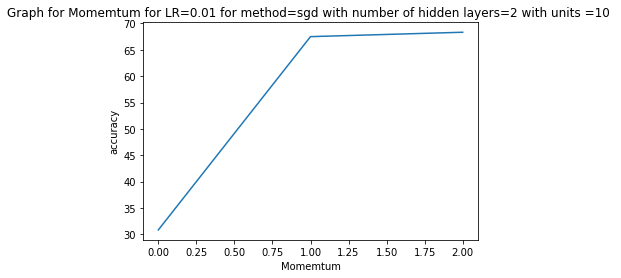

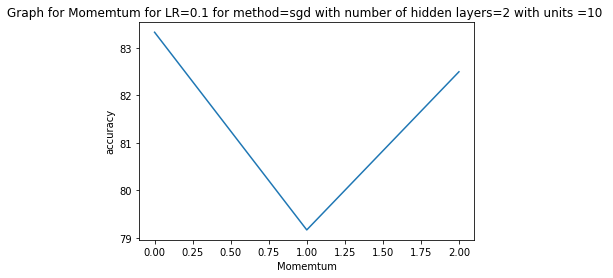

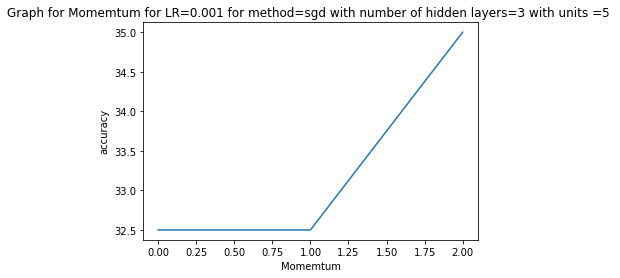

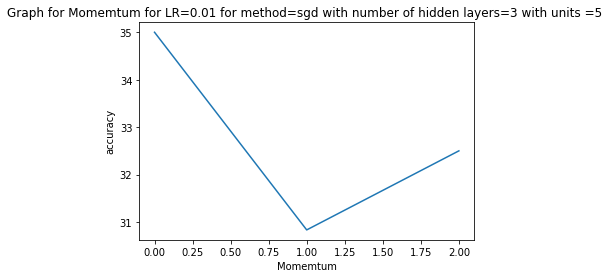

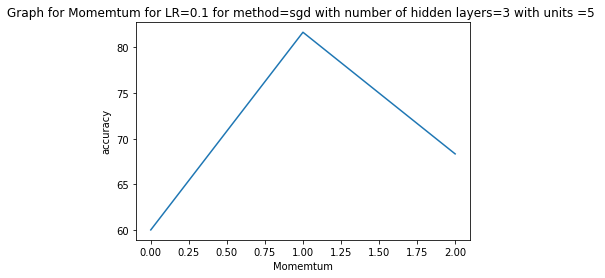

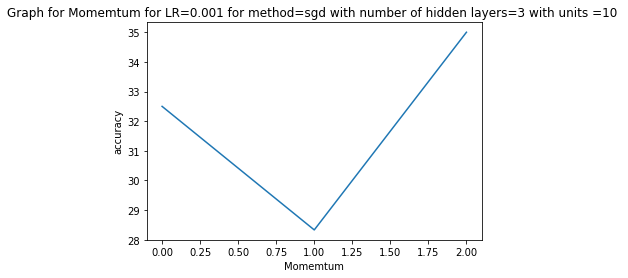

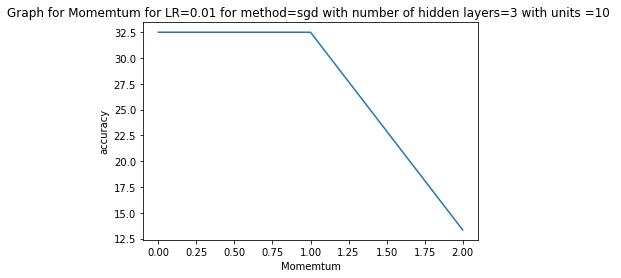

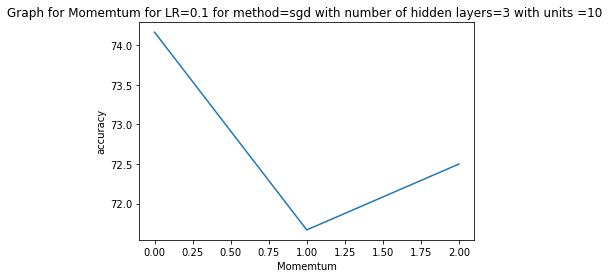

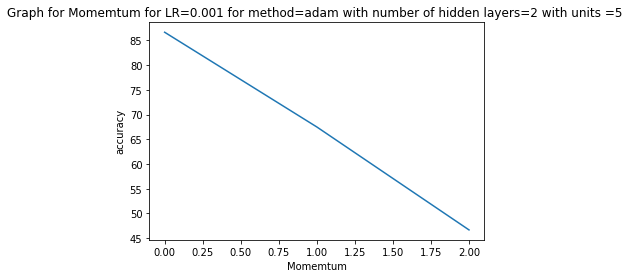

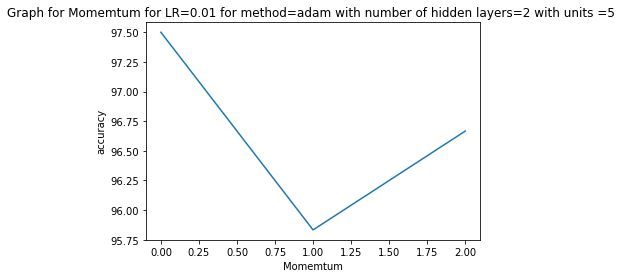

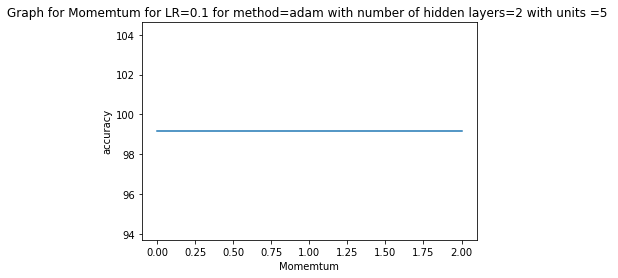

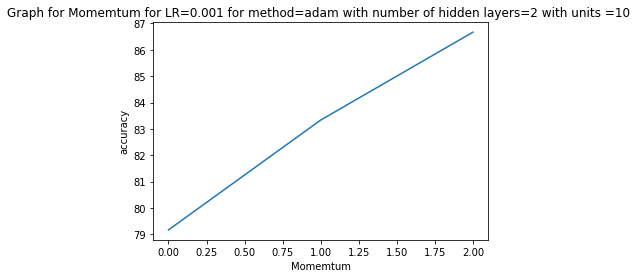

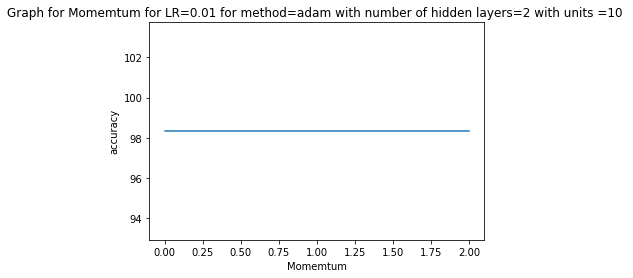

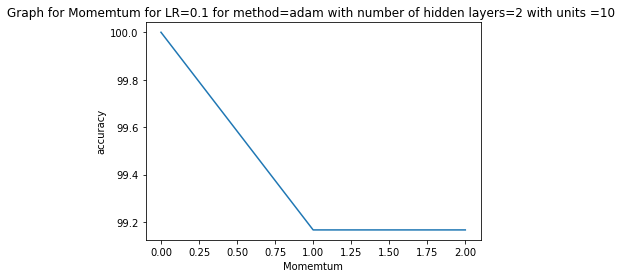

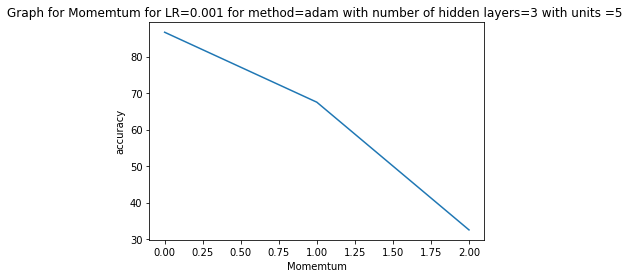

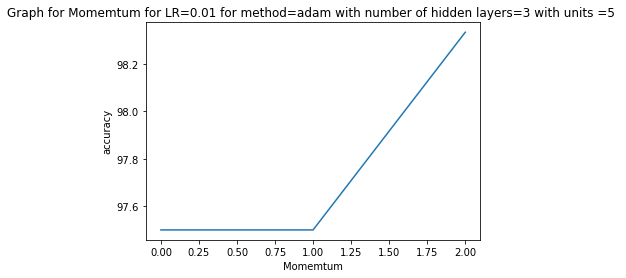

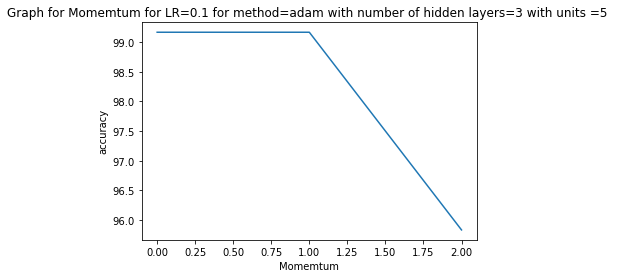

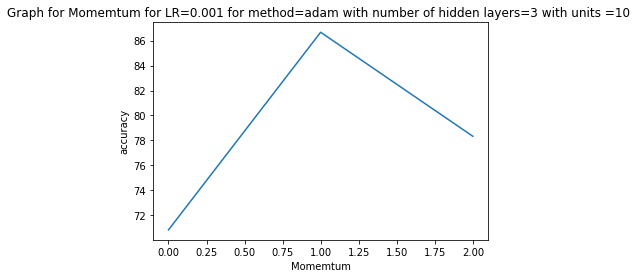

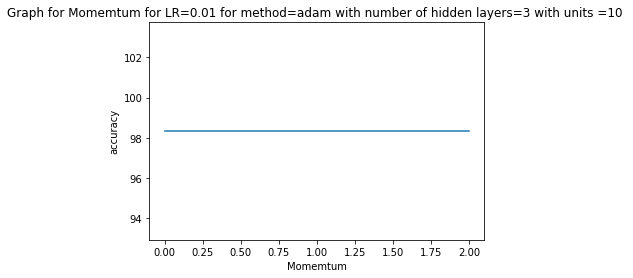

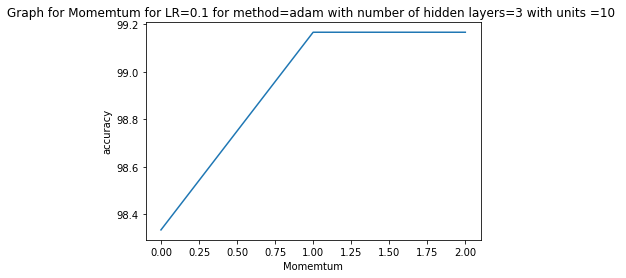

In [0]:
N=X_train.shape[1]
lr1=[0.001, 0.01,0.1]
mr1=[0.001,0.01,0.1]
methods=['sgd','adam']
h1=[[5,5],[10,10],[5,5,5],[10,10,10]]
accg=[]
epoch=100
for method1 in methods:
  for hidden_layers in h1:
    for lr in lr1:
      accg=[]
      for mr in mr1:
        
        acc,cm=classifymodel1(X_train,X_test,T_train,T_test,N,hidden_layers,method1,lr,mr,epoch)
        accg.append(acc)
        #print('For model={} with number of Hidden layers  ={} with  units in each layer={} with learning rate ={} and momemtum rate ={} the accuracy is {}  '.format(method1,len(hidden_layers),hidden_layers[0],lr,mr,acc))
      #print(len(mr1),len(accg))
      plt.plot(accg)
      plt.title('Graph for Momemtum for LR={} for method={} with number of hidden layers={} with units ={} '.format(lr,method1,len(hidden_layers),hidden_layers[0]))
      plt.xlabel('Momemtum')
      plt.ylabel('accuracy')
      plt.show()

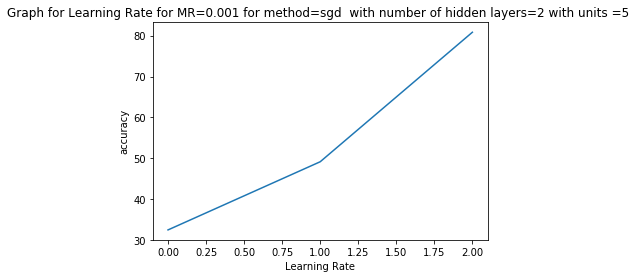

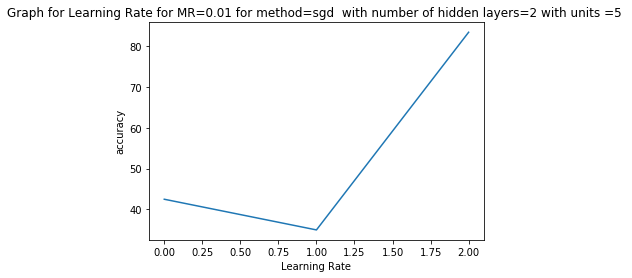

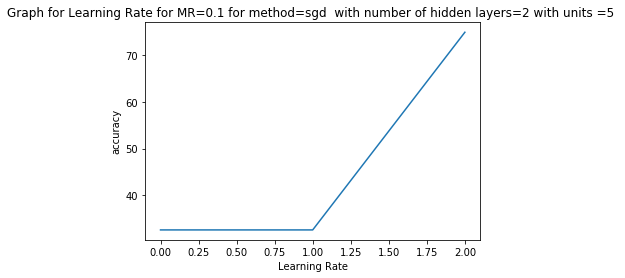

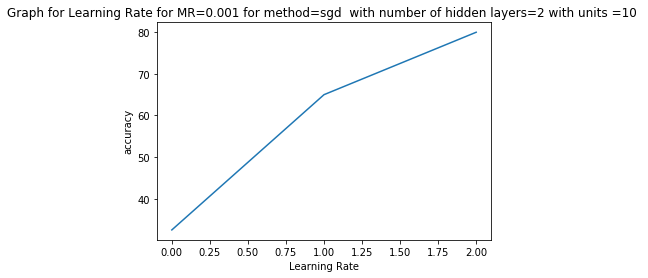

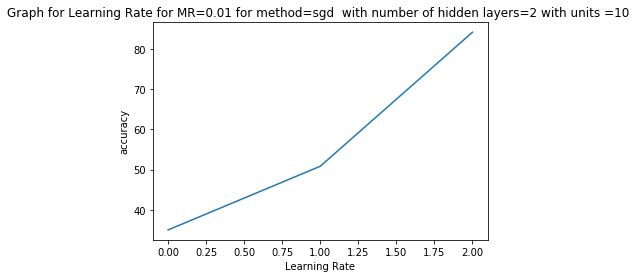

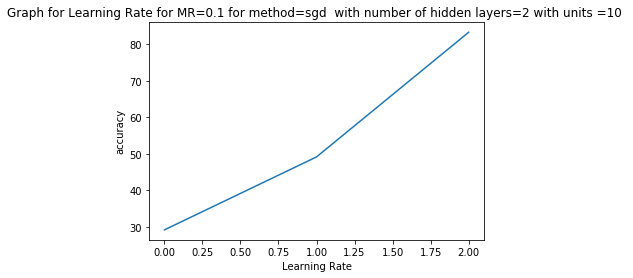

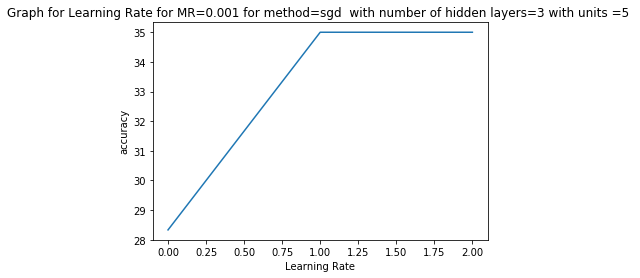

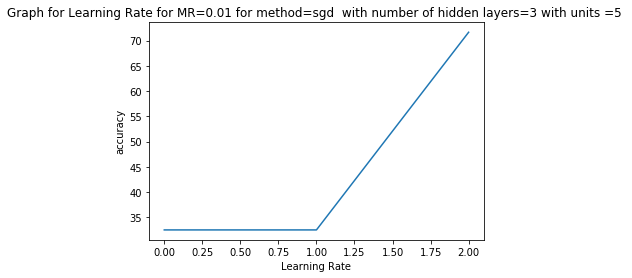

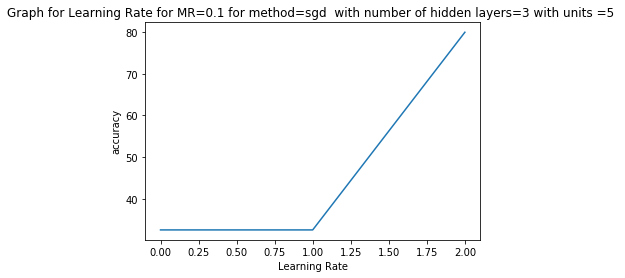

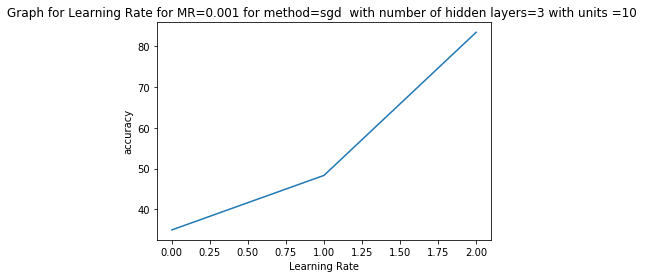

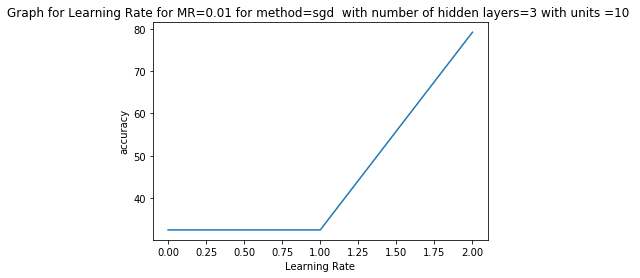

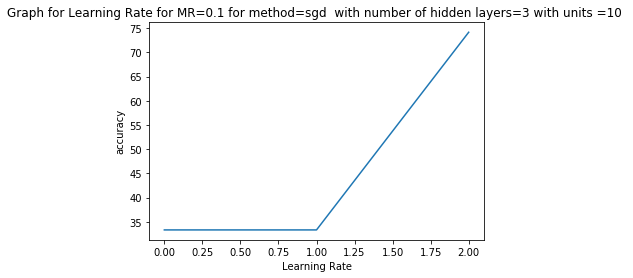

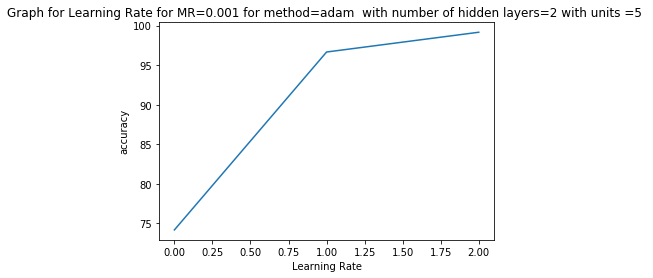

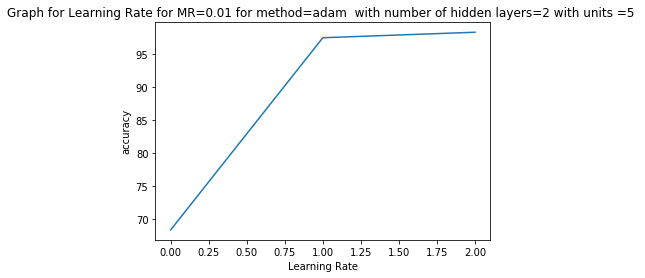

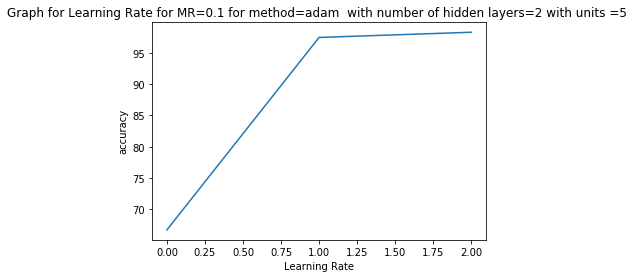

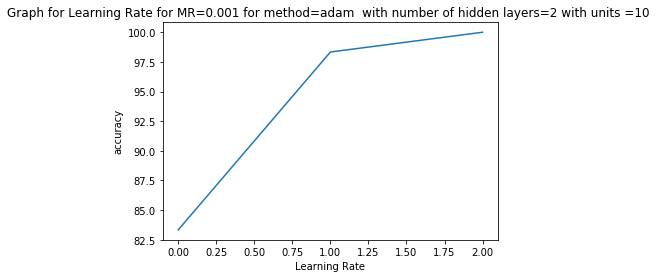

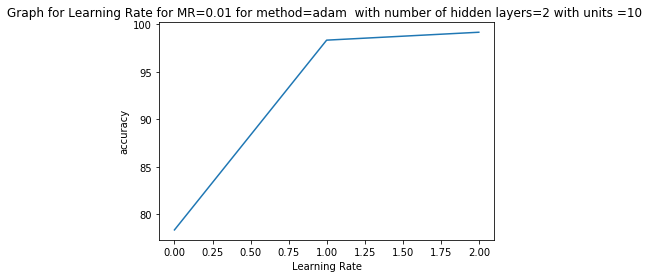

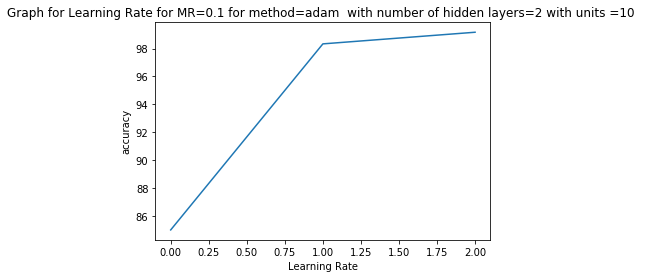

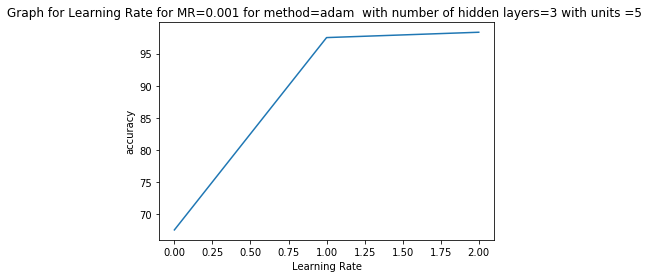

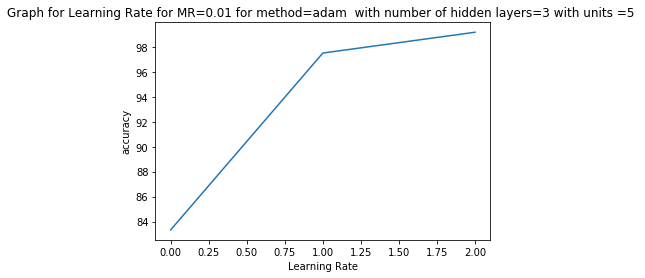

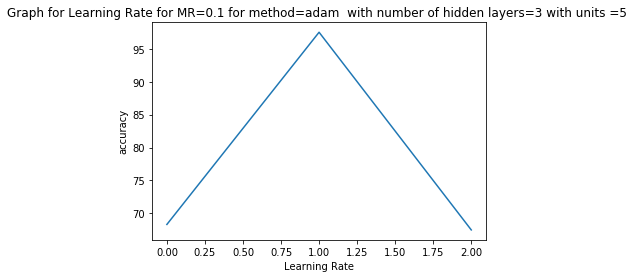

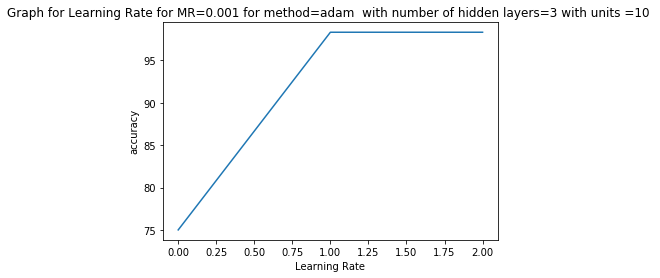

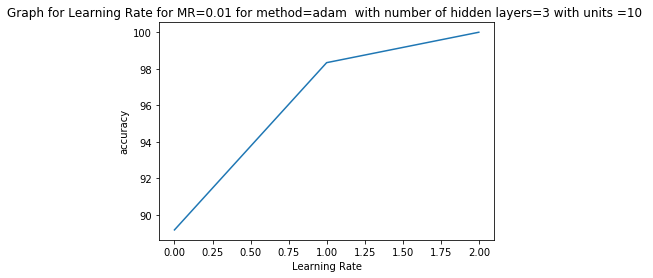

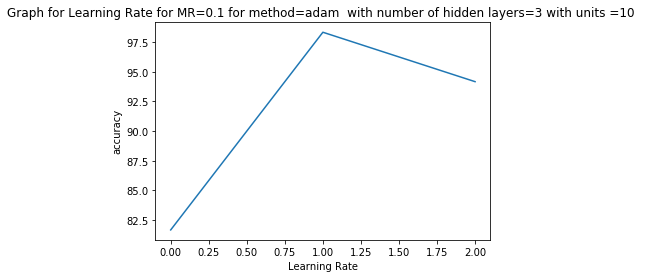

In [0]:
for method1 in methods:
  for hidden_layers in h1:
    for mr in mr1:
      accg=[]
      for lr in lr1:
        
        acc,cm=classifymodel1(X_train,X_test,T_train,T_test,N,hidden_layers,method1,lr,mr,epoch)
        accg.append(acc)
        #print('For model={} with number of Hidden layers  ={} with  units in each layer={} with learning rate ={} and momemtum rate ={} the accuracy is {}  '.format(method1,len(hidden_layers),hidden_layers[0],lr,mr,acc))
      
      plt.plot(accg)
      plt.title('Graph for Learning Rate for MR={} for method={}  with number of hidden layers={} with units ={} '.format(mr,method1,len(hidden_layers),hidden_layers[0]))
      plt.xlabel('Learning Rate')
      plt.ylabel('accuracy')
      plt.show()

Observation is same as with the Testing Values.

Extra Credit Part.

The first Part of Extra Credit has already been done before with the Iris Dataset.
So now proceeding to the Second Part
```



Now writing the first optimizers in gpu

In [0]:
#%%writefile optimizersgpu.py
import numpy as np
import sys
import copy
import time
import math  # for math.ceil
import torch

######################################################################
## sgd

def sgd1(w, error_f, fargs=[], n_iterations=100, error_gradient_f=None,
        eval_f=lambda x: x, save_wtrace=False, verbose=False,
        use_torch=False,
        learning_rate=0.001, momentum_rate=0.0):

    start_time = time.time()
    start_time_last_verbose = start_time

    if use_torch:
        if isinstance(w, np.ndarray):
            w = torch.tensor(w, dtype=torch.float, requires_grad=True).to('cuda')
        else:
            w = w.clone().detach().requires_grad_(True)
        wtrace = [w.clone().detach()] if save_wtrace else None
    else:
        w = w.copy()
        wtrace = [w.copy()] if save_wtrace else None
    
    ftrace = [eval_f(error_f(w, *fargs))]
    
    w_change = 0

    for iteration in range(n_iterations):

        error = error_f(w, *fargs)

        if use_torch:
            error.backward(retain_graph=True)
            with torch.no_grad():
                w_change = -learning_rate * w.grad + momentum_rate * w_change
                w += w_change
                w.grad.zero_()
            if save_wtrace:
                wtrace.append(w.clone().detach())
            ftrace.append(eval_f(error).detach())

        else:
            grad = error_gradient_f(w, *fargs)
            w_change = -learning_rate * grad + momentum_rate * w_change
            w += w_change
            if save_wtrace:
                wtrace.append(w.copy())
            ftrace.append(eval_f(error))

        iterations_per_print = math.ceil(n_iterations/10)
        if verbose and (iteration + 1) % max(1, iterations_per_print) == 0:
            seconds = time.time() - start_time_last_verbose
            eval = eval_f(error) # .item() if use_torch else eval_f(error)
            print(f'sgd: Iteration {iteration+1:d} ObjectiveF={eval:.5f} Seconds={seconds:.3f}')
            start_time_last_verbose = time.time()

    return {'w': w,
            'f': error_f(w, *fargs),
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 2,:] if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 2],
            'reason': 'iterations',
            'time': time.time() - start_time}


######################################################################
## adam
    


######################################################################
# Scaled Conjugate Gradient algorithm from
#  "A Scaled Conjugate Gradient Algorithm for Fast Supervised Learning"
#  by Martin F. Moller
#  Neural Networks, vol. 6, pp. 525-533, 1993
#
#  Adapted by Chuck Anderson from the Matlab implementation by Nabney
#   as part of the netlab library.
#

def scg1(w, error_f, fargs=[], n_iterations=100, error_gradient_f=None,
        eval_f=lambda x: x, save_wtrace=False, verbose=False,
        use_torch=False,
        learning_rate=None, momentum_rate=None):  # not used here

    float_precision = sys.float_info.epsilon

    start_time = time.time()
    start_time_last_verbose = start_time

    if use_torch:
        if isinstance(w, np.ndarray):
            w = torch.tensor(w, dtype=torch.float, requires_grad=True).to('cuda')
        else:
            w = w.clone().detach().requires_grad_(True)
        wtrace = [w.clone()] if save_wtrace else None
        isnan = torch.isnan
        sqrt = torch.sqrt
    else:
        w = w.copy()
        wtrace = [w.copy()] if save_wtrace else None
        isnan = np.isnan
        sqrt = math.sqrt
        
    sigma0 = 1.0e-6
    print(w)
    print(*fargs)
    error_old = error_f(w, *fargs)
    error_now = error_old
    if use_torch:
        error_now.backward(retain_graph=True)
        gradnew = w.grad.clone()
        w.grad.zero_()
        ftrace = [eval_f(error_old).detach()]
    else:
        gradnew = error_gradient_f(w, *fargs)
        ftrace = [eval_f(error_old)]

    gradold = gradnew
    d = -gradnew      # Initial search direction.
    success = True    # Force calculation of directional derivs.
    nsuccess = 0      # nsuccess counts number of successes.
    beta = 1.0e-6     # Initial scale parameter. Lambda in Moeller.
    betamin = 1.0e-15 # Lower bound on scale.
    betamax = 1.0e20  # Upper bound on scale.
    nvars = len(w)
    iteration = 1     # count of number of iterations


    thisIteration = 1

    while thisIteration <= n_iterations:

        if success:
            mu = d.T @ gradnew
            if mu >= 0:
                d = -gradnew
                mu = d.T @ gradnew
            kappa = d.T @ d

            if isnan(kappa):
                print('kappa', kappa)

            if kappa < float_precision:
                return {'w': w,
                        'f': error_now,
                        'n_iterations': iteration,
                        'wtrace': np.array(wtrace)[:iteration + 1, :] if save_wtrace else None, 
                        'ftrace': np.array(ftrace)[:iteration + 1],
                        'reason': 'limit on machine precision',
                        'time': time.time() - start_time}
            sigma = sigma0 / sqrt(kappa)

            if use_torch:
                w_smallstep = (w.detach() + sigma * d).requires_grad_(True)
                err = error_f(w_smallstep, *fargs)
                err.backward(retain_graph=True)
                g_smallstep = w_smallstep.grad.clone()
                w_smallstep.grad.zero_()
            else:
                w_smallstep = w + sigma * d
                error_f(w_smallstep, *fargs)
                g_smallstep = error_gradient_f(w_smallstep, *fargs)

            theta = d.T @ (g_smallstep - gradnew) / sigma
            if isnan(theta):
                print(f'theta {theta} sigma {sigma} d[0] {d[0]} g_smallstep[0] {g_smallstep[0]} gradnew[0] {gradnew[0]}')

        ## Increase effective curvature and evaluate step size alpha.
        delta = theta + beta * kappa
        if isnan(delta):
            print(f'delta is NaN theta {theta} beta {beta} kappa {kappa}')
        elif delta <= 0:
            delta = beta * kappa
            beta = beta - theta / kappa

        if delta == 0:
            success = False
            error_now = error_old
        else:
            alpha = -mu / delta
            ## Calculate the comparison ratio Delta
            if use_torch:
                wnew = (w.detach() + alpha * d).requires_grad_(True)
            else:
                wnew = w + alpha * d
            error_new = error_f(wnew, *fargs)
            Delta = 2 * (error_new - error_old) / (alpha * mu)
            if not isnan(Delta) and Delta  >= 0:
                success = True
                nsuccess += 1
                if use_torch:
                    w = wnew.detach().requires_grad_(True)
                else:
                    w[:] = wnew
                error_now = error_new
            else:
                success = False
                error_now = error_old

        iterations_per_print = math.ceil(n_iterations/10)
        if verbose and thisIteration % max(1, iterations_per_print) == 0:
            seconds = time.time() - start_time_last_verbose
            print(f'SCG: Iteration {iteration:d} ObjectiveF={eval_f(error_now):.5f} Scale={beta:.3e} Seconds={seconds:.3f}')
            start_time_last_verbose = time.time()
        if use_torch:
            if save_wtrace:
                wtrace.append(w.clone().detach())
            ftrace.append(eval_f(error_now).detach())
        else:
            if save_wtrace:
                wtrace.append(w.copy())
            ftrace.append(eval_f(error_now))


        if success:

            error_old = error_new
            gradold[:] = gradnew
            if use_torch:
                error_new.backward(retain_graph=True)
                gradnew = wnew.grad.clone()
                wnew.grad.zero_()
            else:
                gradnew[:] = error_gradient_f(w, *fargs)

            # If the gradient is zero then we are done.
            gg = gradnew.T @ gradnew
            if gg == 0:
                return {'w': w,
                        'f': error_now,
                        'n_iterations': iteration,
                        'wtrace': np.array(wtrace)[:iteration + 1, :] if save_wtrace else None,
                        'ftrace': np.array(ftrace)[:iteration + 1],
                        'reason': 'zero gradient',
                        'time': time.time() - start_time}

        if isnan(Delta) or Delta < 0.25:
            beta = min(4.0 * beta, betamax)
        elif Delta > 0.75:
            beta = max(0.5 * beta, betamin)

        # Update search direction using Polak-Ribiere formula, or re-start
        # in direction of negative gradient after nparams steps.
        if nsuccess == nvars:
            d[:] = -gradnew
            nsuccess = 0
        elif success:
            gamma = (gradold - gradnew).T @ (gradnew / mu)
            d[:] = gamma * d - gradnew

        thisIteration += 1
        iteration += 1

        # If we get here, then we haven't terminated in the given number of iterations.

    return {'w': w,
            'f': error_now,
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 1,:] if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 1],
            'reason': 'did not converge',
            'time': time.time() - start_time}



Now writing Neural Network in gpu

In [0]:
#import optimizersgpu as opt
import numpy as np
import torch
import mlutilities as ml
import matplotlib.pyplot as plt
import copy
class NeuralNetworkgpu:

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, use_torch=False):

        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetwork: n_hiddens_list must be a list.')
 
        if len(n_hiddens_list) == 0:
            self.n_hidden_layers = 0
        elif n_hiddens_list[0] == 0:
            self.n_hidden_layers = 0
        else:
            self.n_hidden_layers = len(n_hiddens_list)
            
        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        
        # Do we have any hidden layers?
        self.Vs = []
        ni = n_inputs
        for layeri in range(self.n_hidden_layers):
            n_in_layer = self.n_hiddens_list[layeri]
            self.Vs.append(1 / np.sqrt(1 + ni) * np.random.uniform(-1, 1, size=(1 + ni, n_in_layer)))
            ni = n_in_layer
        self.W = 1/np.sqrt(1 + ni) * np.random.uniform(-1, 1, size=(1 + ni, n_outputs))
        if use_torch:
            self.Vs = [torch.tensor(V, dtype=torch.float).to('cuda') for V in self.Vs]
            self.W = torch.tensor(self.W, dtype=torch.float).to('cuda')
            self.tanh = torch.tanh
            self.mean = torch.mean
            self.sqrt = torch.sqrt
        else:
            self.tanh = np.tanh
            self.mean = np.mean
            self.sqrt = np.sqrt

        self.use_torch = use_torch
        
        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        
        self.trained = False
        self.reason = None
        self.error_trace = None
        self.n_epochs = None
        self.training_time = None

    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, use_torch={self.use_torch})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str

    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result

    def _unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans

    def _pack(self, Vs, W):
        if self.use_torch:
            return torch.cat([V.reshape(-1) for V in Vs] + [W.reshape(-1)])
        else:
            return np.hstack([V.flat for V in Vs] + [W.flat])

    def _unpack(self, w):
        first = 0
        n_this_layer = self.n_inputs
        for i in range(self.n_hidden_layers):
            self.Vs[i][:] = w[first:first + (1 + n_this_layer) * 
                              self.n_hiddens_list[i]].reshape((1 + n_this_layer, self.n_hiddens_list[i]))
            first += (1 + n_this_layer) * self.n_hiddens_list[i]
            n_this_layer = self.n_hiddens_list[i]
        self.W[:] = w[first:].reshape((1 + n_this_layer, self.n_outputs))

    def _forward_pass(self, X):
        # Assume weights already unpacked
        Z_prev = X  # output of previous layer
        Z = [Z_prev]
        for i in range(self.n_hidden_layers):
            V = self.Vs[i]
            Z_prev = self.tanh(Z_prev @ V[1:, :] + V[0:1, :])
            Z.append(Z_prev)
        
        Y = Z_prev @ self.W[1:, :] + self.W[0:1, :]
        return Y, Z

    def _objectiveF(self, w, X, T):
        self._unpack(w)
        Y, _ = self._forward_pass(X)
        return 0.5 * self.mean((T - Y)**2)

    # Only used if use_torch=False
    def _gradientF(self, w, X, T):
        self._unpack(w)
        Y, Z = self._forward_pass(X)
        # Do backward pass, starting with delta in output layer
        delta = -(T - Y) / (X.shape[0] * T.shape[1])
        # Another way to define dEdW without calling np.insert                        
        dW = np.vstack((np.sum(delta, axis=0), Z[-1].T @ delta))
        dVs = []
        delta = (1 - Z[-1]**2) * (delta @ self.W[1:, :].T)
        for Zi in range(self.n_hidden_layers, 0, -1):
            Vi = Zi - 1  # because X is first element of Z
            dV = np.vstack((np.sum(delta, axis=0), Z[Zi-1].T @ delta))
            dVs.insert(0, dV)  # like append, but at front of list of dVs
            delta = (delta @ self.Vs[Vi][1:, :].T) * (1 - Z[Zi-1]**2)
        return self._pack(dVs, dW)

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy.copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
        
    def _objective_to_actual(self, objective):
        return self.sqrt(objective)
    
    def train(self, X, T, n_epochs, method='scg',
              verbose=False, save_weights_history=False,
              learning_rate=0.001, momentum_rate=0.0): # only for sgd and adam

        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]}) not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float).to('cuda')  # 32 bit
            T = torch.tensor(T, dtype=torch.float).to('cuda')

        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
        
        try:
            algo = [sgd1,  scg1][['sgd', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            
        result = algo(self._pack(self.Vs, self.W),
                      self._objectiveF,
                      [X, T], n_epochs,
                      self._gradientF,  # not used if scg
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch,
                      save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] # * self.Tstds # to _unstandardize the MSEs
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self

    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float).to('cuda')
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        return (Y, Z[1:]) if all_outputs else Y

    def get_n_epochs(self):
        return self.n_epochs

    def get_error_trace(self):
        return self.error_trace

    def get_training_time(self):
        return self.training_time

    def get_weight_history(self):
        return self.weight_history

    def draw(self, input_names=None, output_names=None, gray=False):
        if self.use_torch:
            Vs = [V.detach().cpu().numpy() for V in self.Vs]
            W = self.W.detach().cpu().numpy()
        else:
            Vs = self.Vs
            W = self.W
        ml.draw(Vs, W, input_names, output_names, gray)
 

Now testing the neural network

Called np.random.seed(42)
tensor([-0.1774,  0.6374,  0.3281,  0.1395, -0.4865, -0.4865, -0.6250,  0.5179,
         0.1430,  0.2943, -0.3914,  0.3837,  0.2714, -0.2349, -0.2598, -0.2585,
        -0.1598,  0.0202, -0.0556, -0.1705,  0.0913, -0.2944, -0.1697, -0.1091,
        -0.0359,  0.2328, -0.2452,  0.0116,  0.0755, -0.3703,  0.0878, -0.2690,
        -0.3551,  0.3665,  0.3802,  0.2518, -0.1595, -0.3285,  0.1504, -0.0489,
        -0.3086, -0.0039, -0.3802,  0.3342, -0.1970,  0.1327], device='cuda:0',
       requires_grad=True)
tensor([[-1.4863],
        [-1.1560],
        [-0.8257],
        [-0.4954],
        [-0.1651],
        [ 0.1651],
        [ 0.4954],
        [ 0.8257],
        [ 1.1560],
        [ 1.4863]], device='cuda:0') tensor([[-1.0069],
        [-0.9716],
        [-0.8656],
        [-0.6889],
        [-0.4416],
        [-0.1237],
        [ 0.2650],
        [ 0.7243],
        [ 1.2542],
        [ 1.8548]], device='cuda:0')
scg  [5, 5] use_torch=True RMSE 0.232 took 20.019 s

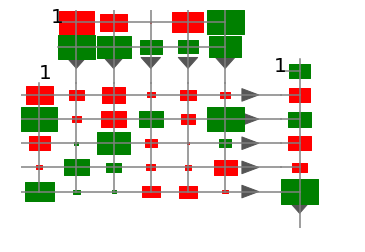

In [17]:
import numpy as np
#import optimizers as opt


np.random.seed(42)
print('Called np.random.seed(42)')
    
X = np.arange(10).reshape((-1, 1))
T = X ** 2
n_epochs = 200

def rmse(Y, T):
        return np.sqrt(np.mean((T - Y)**2))
    
for use_torch in [ True]:

        #nnet = NeuralNetwork(1, [], 1, use_torch=use_torch)
        # Equivalent to
        # nnet = NeuralNetwork(1, [0], 1, use_torch=use_torch)
        #nnet.train(X, T, n_epochs)
        #Y = nnet.use(X)
        #print(f'scg  {nnet.n_hiddens_list} use_torch={use_torch} RMSE {rmse(Y, T):.3f} took {nnet.training_time:.3f} seconds')

        nnet = NeuralNetworkgpu(1, [5, 5], 1, use_torch=use_torch)
        nnet.train(X, T, n_epochs)
        Y = nnet.use(X)
        print(f'scg  {nnet.n_hiddens_list} use_torch={use_torch} RMSE {rmse(Y, T):.3f} took {nnet.training_time:.3f} seconds')

        nnet = NeuralNetworkgpu(1, [5, 5], 1, use_torch=use_torch)
        nnet.train(X, T, n_epochs, method='sgd', learning_rate=0.5, momentum_rate=0.5)
        Y = nnet.use(X)
        print(f'sgd  {nnet.n_hiddens_list} use_torch={use_torch} RMSE {rmse(Y, T):.3f} took {nnet.training_time:.3f} seconds')

        

plt.figure(1)
plt.clf()
nnet.draw()

It can be seen that scg and sgd are taking a lot of time in computing in the gpu. The reason may be the conversion time of gpu to cpu. Although for a large amount of data that number may vary

In [14]:
#%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Roy-A3.ipynb' and storing in notebookcode.py


SyntaxError: ignored